# METU Ceng 798 - Quantum Computing Term Project
## Grover's Algorithm for String Matching
### Mert Tunc - 2023 Spring

In this project, we will implement [Grover's algorithm](https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm) for string matching. The problem is defined as follows:
>Given a string $w$ of length $n$ and a pattern $p$ of length $m$, find all the starting positions of $p$ in $w$.

In the literature, there are papers claiming they solved the string matching problem with the help of Grover's algorithm. I reviewed the following three during my literature search.

[1] https://doi.org/10.1038/s41534-021-00369-3

[2] https://www.sciencedirect.com/science/article/pii/S1570866703000108

[3] https://diposit.ub.edu/dspace/bitstream/2445/188047/1/BARBER%C3%80%20RODR%C3%8DGUEZ%20J%C3%9ALIA_6057590_assignsubmission_file_TFG-Barbera-Rodriguez-Julia.pdf

I started my term project trying to replicate what is shared in paper [3], and couldn't replicate what authors shared. I then tried to alter what I think would be better and successfully improved their implementation in terms of:
- Accuracy: Results they shared does not suggest the solutions by a statistically significant amount.
- Efficiency: I have reduced the number of required qubits for the same sized input compared to it.

My initial plan was to implement paper [3], and improve it with ideas I could get from papers [1] and [2], but as I couldn't replicate the results of paper [3], I decided to implement my own solution.

So, in this project, I ended up with implementing my own solution to the string matching problem with the help of Grover's algorithm. It seems like a novel approach to the problem, but it is very naive, so it suits more in the form of a tutorial.


---


Let's start by importing the required libraries.

In [1]:
import math

from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

And define the variables we'll use.
As in the problem statement, we have $w$ and $p$ as the string and the pattern respectively. For our application, we'll use $w$ and $p$ as binary strings.

In the implementation, it is assumed that the $n$ and $m$ have a length of power 2.

In [2]:
inp_w = "1101"
inp_p = "01"

In [3]:
n = len(inp_w)
m = len(inp_p)

In [4]:
assert n >= m, "n must be greater than m"
assert m >= 1, "m must be greater than 0"
assert 2 ** int(math.log2(n)) == n, "n must be a power of 2"
assert 2 ** int(math.log2(m)) == m, "m must be a power of 2"

We can now start implementing the actual solution, after taking a high-level look on what we'll be implementing.

Grover's search algorithm shares a framework with us on how to implement unstructured search with a time complexity of $O(\sqrt{n})$
The framework is as follows:
- Initialize the state $|s\rangle$ to a uniform superposition of all possible states.
- Repeat the following steps $O(\sqrt{n})$ times:
    - Apply the Grover's oracle $U_f$ to the state $|s\rangle$.
    - Apply the Grover's diffusion operator $U_s$ to the state $|s\rangle$.
- Measure the state $|s\rangle$.

Following image is an illustration of the steps of Grover's Algorithm
![Grovers Illustration](https://learn.qiskit.org/content/v2/ch-algorithms/images/grover_circuit_high_level.png)


In our application, the states that we want to search are consist of the starting index of the pattern in the string. The challenge in the string search problem is that, each state brings more than one constraint.

e.g For the values we have $w = 1101$ and $p = 01$, the states we will be searching are $00, 01, 10$. (MENTION ABOUT FINDING STATE LENGTH)

Following the same example, state $01$(decimal 1, as the start index of $p$ in $w$) means that:
- $w_1$ = $p_0$
- $w_2$ = $p_1$


Generalization of these constraints for any $w$ and $p$ is as follows:
Given:
- A state s in binary form representing the start position of the match
- A $p$ of length $k$:
Constraints to check if the state $s$ is a match:
- $w_{s + 0} = p_0$
- $w_{s + 1} = p_1$
- ...
- $w_{s + k} = p_k$

Let's implement these checks in our oracle. There are few additional considerations we need to have for the implementation:
- Checking if a bit in $w$ and $p$ being equal requires these bits to _flipped_ to 1 before the operation and after the operation if these bits are 0(Since we'll use _multi-input and gates_, [mcx](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.mcx.html).
- Similarly, we'll need to _flip_ the bits of $s$ if the bits are 0.
- For each constraint, we'll store value of the equivalence(e.g $w_{s + 1} = p_1$) in a intermediate qubit, then use a _multi-controlled and gate_ to _and_ all of them to a single qubit. We'll call these intermediate qubits `bit_matches`, having total length of $p$, and the final qubit as `match`.


So define the circuit first and initialize the $s$ with Hadamard gates.

In [5]:
num_sbits = math.ceil(math.log2(n - m)) + 1 # Number of bits required for s to encode all possible start indexes of matches

s = QuantumRegister(num_sbits, 's_list')
#s_chunks = list(list_to_chunks(s_list, num_sbits))
w = QuantumRegister(n, 'w') # w is the string to be searched
p = QuantumRegister(m, 'p') # p is the pattern to be searched in w
bit_matches = QuantumRegister(m, 'bit_matches') # bit_matches is the intermediate qubits to store the individual constraints
match = QuantumRegister(1, 'match') # match is the final qubit to store the result of the oracle

qc = QuantumCircuit(s, w, p, bit_matches, match) # all qubits will have starting state of |0>

In [6]:
def set_inputs(qc, inp_w, inp_p):
    """Negate the initial |0> states of s correspondingly to the input w and p"""
    for i, c in enumerate(inp_w):
        if c == "1":
            qc.x(w[i])

    for i, c in enumerate(inp_p):
        if c == "1":
            qc.x(p[i])


def initialize_s(qc):
    """Apply H gates to all qubits in s"""
    qc.h(s)


In [7]:
set_inputs(qc, inp_w, inp_p)
initialize_s(qc)

Now, we can define an oracle that checks the constraints we defined above.

In [8]:
# Note that, in strict terms, this is not the complete oracle, but a part of it.
# In our circuit builder code, we'll call this method several times with different start positions,
# and then apply the mxc gates to the bit_matches and match qubits.
# After that, we'll once again call this method for all starting positions
# to revert the qubits back to their original state.
def oracle(qc: QuantumCircuit, start_pos):
    format_string = "{:0" + str(len(s)) + "b}"
    pos_in_binary = format_string.format(start_pos)

    # flipped_xyz variables will hold which qubits are flipped in the oracle to revert them back after the mxc gates.
    # Recall that we need to flip bits when they are 0 to be able to use them as a condition on mcx gate.
    flipped_s = []
    for k, pos in enumerate(pos_in_binary):
        if pos == "0":
            flipped_s.append(s[k])
            qc.x(s[k])

    # Following loop will create the $w_{s + k} = p_k$ for each bit in p
    # offset is the k, match_bit is the intermediate qubit to store the result of the constraint
    for offset, match_bit in enumerate(bit_matches):
        flipped_w = []
        flipped_p = []

        if inp_p[0 + offset] == "0":
            flipped_p.append(p[0 + offset])
            qc.x(p[0 + offset])

            flipped_w.append(w[0 + start_pos + offset])
            qc.x(w[0 + start_pos + offset])

        # Following gate can be read as: For the current state of s , if w[start_pos + offset] and p[0 + offset] is the same
        # Apply X gate to bit_matches[offset], to store the result of the constraint
        # This is the part we introduce the constraints of the problem to the circuit
        qc.mcx(list(s) + [w[start_pos + offset], p[0 + offset]], bit_matches[offset])

        # Revert what we flipped to have 1 in mcx inputs
        if len(flipped_w):
            qc.x(flipped_w)
        if len(flipped_p):
            qc.x(flipped_p)

    if len(flipped_s):
        qc.x(flipped_s)

In addition to the oracle, we'll also need to define the diffusion operator. The diffusion operator is defined as follows:

In [9]:
def diffusion(qc: QuantumCircuit):
    """Apply a diffusion circuit to the register 's' in qc"""
    qc.h(s)
    qc.x(s)

    qc.mcx(s, match)
    qc.z(match)

    qc.x(s)
    qc.h(s)

Now, we are almost done, we need to apply these oracle and diffusion opeartors $O(\sqrt{N})$ times, where $N$ is $\sqrt(2*len(s))$

In [10]:
# Following line and barriers on qc is for demonstration purposes only
format_string = "{:0" + str(len(s)) + "b}"

num_repetitions = int(math.sqrt(2 ** num_sbits))
for repetition in range(num_repetitions):
    qc.barrier(label=f"Oracle start")
    for start_pos in range(n - m + 1):
        pos_in_binary = format_string.format(start_pos)
        qc.barrier(label=f"{pos_in_binary} St.")
        # Apply the oracle, and then extract the match qubit if all intermediate bit_matches are 1,
        # then apply the oracle again to revert the changes we made on bit_matches
        oracle(qc, start_pos)
        qc.mcx(bit_matches, match)
        oracle(qc, start_pos)

        qc.barrier(label=f"{pos_in_binary} End.")
    # We then apply the diffusion operator to rotate all probabilities of the states around the mean.
    qc.barrier(label=f"Diffusion start")

    diffusion(qc)


To measure what we got on $s$ qubits, we define a measurement and append that to the circuit.

In [11]:
def measurement_s(qc):
    num_bits = len(s)
    meas = QuantumCircuit(num_bits, num_bits)
    meas.measure(list(range(num_bits)), list(range(num_bits)))
    qc.compose(meas, inplace=True, qubits=s)

measurement_s(qc)

Then, run the circuit on a simulator and plot the results.

In [12]:
def execute_on_sim(qc, num_shots=100):
    backend = provider.get_backend('ibmq_qasm_simulator')
    result = backend.run(transpile(qc, backend), shots=num_shots).result()
    return result.get_counts(qc)


counts = execute_on_sim(qc)

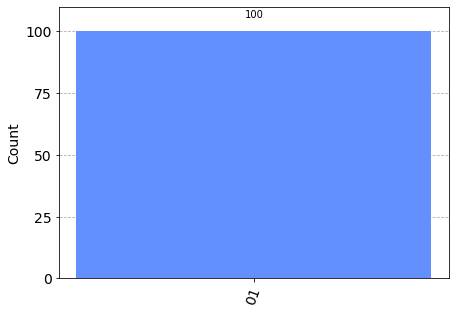

In [13]:
plot_histogram(counts)

In the above plot, we can see that on 100 shots on simulator, we got only the $10$ match, which is 2 in decimal notation.(Qiskit uses little endian notation, so we read the value $01$ as $10$, and convert it to decimal notation)
Our $w$ was $1101$ and $p$ was $01$, and we got the correct result. There is indeed a match for $p$ in $w$ starting from the index 2 in $w$.

Let's see the circuit we built.

In [14]:
qc.draw(fold=65)

┌───┐ Oracle start  00 St. ┌───┐               »
     s_list_0: ┤ H ├──────░──────────░────┤ X ├──■─────────■──»
               ├───┤      ░          ░    ├───┤  │         │  »
     s_list_1: ┤ H ├──────░──────────░────┤ X ├──■─────────■──»
               ├───┤      ░          ░    ├───┤  │  ┌───┐  │  »
          w_0: ┤ X ├──────░──────────░────┤ X ├──■──┤ X ├──┼──»
               ├───┤      ░          ░    └───┘  │  └───┘  │  »
          w_1: ┤ X ├──────░──────────░───────────┼─────────■──»
               └───┘      ░          ░           │         │  »
          w_2: ───────────░──────────░───────────┼─────────┼──»
               ┌───┐      ░          ░           │         │  »
          w_3: ┤ X ├──────░──────────░───────────┼─────────┼──»
               └───┘      ░          ░    ┌───┐  │  ┌───┐  │  »
          p_0: ───────────░──────────░────┤ X ├──■──┤ X ├──┼──»
               ┌───┐      ░          ░    └───┘  │  └───┘  │  »
          p_1: ┤ X ├──────░──────────░───────────┼─────────■──»
               └───┘      ░          ░         ┌─┴─┐       │  »
bit_matches_0: ───────────░──────────░─────────┤ X ├───────┼──»
                          ░          ░         └───┘     ┌─┴─┐»
bit_matches_1: ───────────░──────────░───────────────────┤ X ├»
                          ░          ░                   └───┘»
        match: ───────────░──────────░────────────────────────»
                          ░          ░                        »
          c: 2/═══════════════════════════════════════════════»
                                                              »
«               ┌───┐┌───┐               ┌───┐ 00 End.  01 St. »
«     s_list_0: ┤ X ├┤ X ├──■─────────■──┤ X ├────░───────░────»
«               ├───┤├───┤  │         │  ├───┤    ░       ░    »
«     s_list_1: ┤ X ├┤ X ├──■─────────■──┤ X ├────░───────░────»
«               ├───┤└───┘  │  ┌───┐  │  └───┘    ░       ░    »
«          w_0: ┤ X ├───────■──┤ X ├──┼───────────░───────░────»
«               └───┘       │  └───┘  │           ░       ░    »
«          w_1: ────────────┼─────────■───────────░───────░────»
«                           │         │           ░       ░    »
«          w_2: ────────────┼─────────┼───────────░───────░────»
«                           │         │           ░       ░    »
«          w_3: ────────────┼─────────┼───────────░───────░────»
«               ┌───┐       │  ┌───┐  │           ░       ░    »
«          p_0: ┤ X ├───────■──┤ X ├──┼───────────░───────░────»
«               └───┘       │  └───┘  │           ░       ░    »
«          p_1: ────────────┼─────────■───────────░───────░────»
«                         ┌─┴─┐       │           ░       ░    »
«bit_matches_0: ──■───────┤ X ├───────┼───────────░───────░────»
«                 │       └───┘     ┌─┴─┐         ░       ░    »
«bit_matches_1: ──■─────────────────┤ X ├─────────░───────░────»
«               ┌─┴─┐               └───┘         ░       ░    »
«        match: ┤ X ├─────────────────────────────░───────░────»
«               └───┘                             ░       ░    »
«          c: 2/═══════════════════════════════════════════════»
«                                                              »
«               ┌───┐               ┌───┐┌───┐               »
«     s_list_0: ┤ X ├──■─────────■──┤ X ├┤ X ├──■─────────■──»
«               └───┘  │         │  └───┘└───┘  │         │  »
«     s_list_1: ───────■─────────■──────────────■─────────■──»
«                      │         │              │         │  »
«          w_0: ───────┼─────────┼──────────────┼─────────┼──»
«               ┌───┐  │  ┌───┐  │  ┌───┐       │  ┌───┐  │  »
«          w_1: ┤ X ├──■──┤ X ├──┼──┤ X ├───────■──┤ X ├──┼──»
«               └───┘  │  └───┘  │  └───┘       │  └───┘  │  »
«          w_2: ───────┼─────────■──────────────┼─────────■──»
«                      │         │              │         │  »
«          w_3: ───────┼─────────┼──────────────┼─────────┼──»
«               ┌───┐  │  ┌───┐  │


---


Now, let's see the limits of the implementation. We'll try to search for a pattern of length 2 in a string of length 8. We'll also try the code with more than one occurrence of $p$ inside $w$.

Lets re-define $w$, and $p$

In [15]:
inp_w = "10110001"
inp_p = "01"
n = len(inp_w)
m = len(inp_p)

In [16]:
assert n >= m, "n must be greater than m"
assert m >= 1, "m must be greater than 0"
assert 2 ** int(math.log2(n)) == n, "n must be a power of 2"
assert 2 ** int(math.log2(m)) == m, "m must be a power of 2"

In [17]:
num_sbits = math.ceil(math.log2(n - m)) + 1 # Number of bits required for s to encode all possible start indexes of matches

s = QuantumRegister(num_sbits, 's_list')
#s_chunks = list(list_to_chunks(s_list, num_sbits))
w = QuantumRegister(n, 'w') # w is the string to be searched
p = QuantumRegister(m, 'p') # p is the pattern to be searched in w
bit_matches = QuantumRegister(m, 'bit_matches') # bit_matches is the intermediate qubits to store the individual constraints
match = QuantumRegister(1, 'match') # match is the final qubit to store the result of the oracle

qc = QuantumCircuit(s, w, p, bit_matches, match) # all qubits will have starting state of |0>

In [18]:
set_inputs(qc, inp_w, inp_p)
initialize_s(qc)

num_repetitions = int(math.sqrt(2 ** num_sbits))
for repetition in range(num_repetitions):
    for start_pos in range(n - m + 1):
        oracle(qc, start_pos)
        qc.mcx(bit_matches, match)
        oracle(qc, start_pos)
    diffusion(qc)

measurement_s(qc)

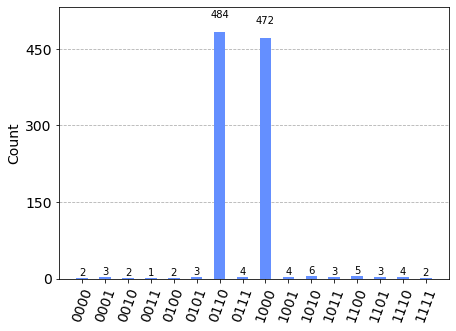

In [19]:
import time

start_time = time.monotonic()

counts = execute_on_sim(qc, num_shots=1000)
plot_histogram(counts)

In [20]:
# Keep in mind that we are using IBM's simulator, and it is on their backend.
print('Elapsed seconds(For 1000 shots on simulator): ', time.monotonic() - start_time)

Elapsed seconds(For 1000 shots on simulator):  47.207864107999995


It is clearly visible that the states $0001$(1 in decimal) and $0110$(6 in decimal) is the most probable states, which are the correct answers for our input $w$ = "10110001" and $p$ = "01".